# 🧪 Lab 08: Clustering Unlabelled Data (Final Student Notebook)

**Goal:** Segment customers using unsupervised learning and **justify** your choices using plots and metrics.

✅ This notebook is designed for a **2-hour lab**:
- Brief concept notes (Markdown)
- Short code blocks
- Some **TODO cells** for students to complete

---
## 🎯 Learning Objectives
- Understand the idea of **unsupervised learning** (no labels)
- Identify why **scaling + transformation** matter for distance-based methods
- Apply **K-Means**, **Hierarchical (Agglomerative)**, and **DBSCAN**
- Evaluate clustering using **inertia (elbow)** and **silhouette score**
- Interpret clusters using simple visualisations

## ✅ Learning Outcomes
By the end, you can:
- Produce a customer segmentation with **clear justification**
- Explain what skewness/outliers do to clustering
- Compare methods and discuss when each is appropriate

## 📦 Dataset
Wholesale Customers dataset (CSV): **`Wholesale_customers_data.csv`** (keep in the same folder).


---
## 0) Setup
### What happens here
- Import libraries
- Set a random seed for reproducibility
- Keep output clean


In [3]:
import os, warnings
os.environ["LOKY_MAX_CPU_COUNT"] = "1"  # Windows-safe
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.preprocessing import PowerTransformer, MinMaxScaler
from sklearn.metrics import silhouette_score

random_state = 42


---
## 1) Load the Data
### What happens here
- Load the dataset from CSV
- Inspect shape + first rows

💡 If you get a *file not found* error, check the CSV name and folder.


In [4]:
X0 = pd.read_csv("Wholesale_customers_data.csv")
print("Shape:", X0.shape)
X0.head()


Shape: (440, 8)


,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


---
## 2) Quick EDA (Raw Data)
### What happens here
- Boxplots reveal **skewness** and **outliers**
- Raw customer spending data is typically right-skewed (few very large spenders)

✍️ **Student task:** Write 2–3 lines answering:
1) Which variables have the strongest outliers?
2) Why can this be a problem for distance-based clustering?


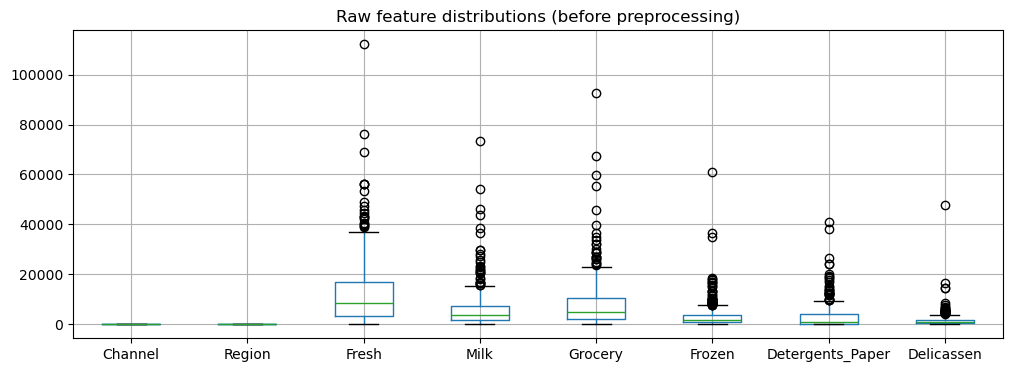

In [5]:
X0.boxplot(figsize=(12,4))
plt.title("Raw feature distributions (before preprocessing)")
plt.show()


### ✍️ Student Answer (write here)
- **Outliers:** ...
- **Why it matters:** ...


---
## 3) Preprocessing (Transformation + Scaling)
### Why we do this
Distance-based clustering (K-Means, Ward linkage) depends on Euclidean distances. If features have different scales or strong skewness:
- large-scale variables dominate the distance
- outliers pull cluster centres

### Technique used
- **PowerTransformer**: reduces skewness (makes distributions more symmetric)
- **MinMaxScaler**: maps features to **[0, 1]** so no single feature dominates


#### ✅ Provided code (run as-is)
We will transform only the spending columns (from `Fresh` onward).

In [6]:
# TODO (student): define the spending columns (all columns from index 2 onward)
spend_cols = X0.columns[2:]  # <-- keep this line, but make sure you understand it

pt = PowerTransformer()
X_spend = pt.fit_transform(X0[spend_cols])

# Combine Channel/Region + transformed spending
X_transf = pd.concat([X0[["Channel","Region"]], pd.DataFrame(X_spend, columns=spend_cols)], axis=1)

scaler = MinMaxScaler()
X = scaler.fit_transform(X_transf)

print("Preprocessing complete. X shape =", X.shape)


Preprocessing complete. X shape = (440, 8)


### Visual check (after preprocessing)
**Expected:** all boxplots now lie between 0 and 1, skewness is reduced.


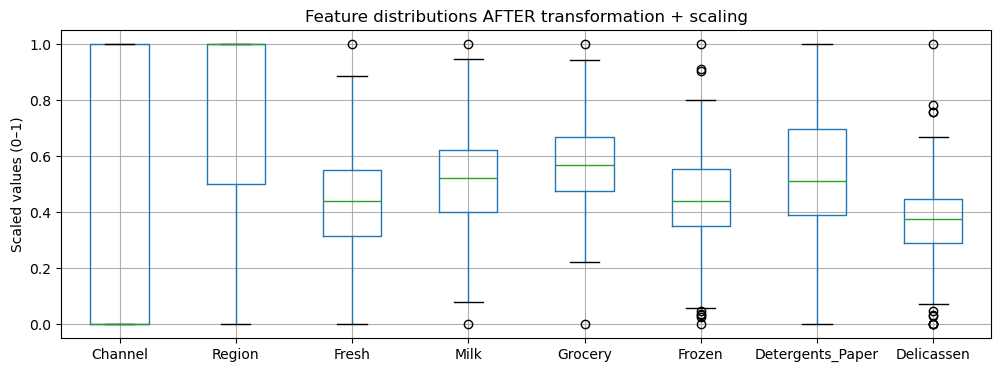

In [7]:
X_preprocessed = pd.DataFrame(X, columns=X_transf.columns)

X_preprocessed.boxplot(figsize=(12,4))
plt.title("Feature distributions AFTER transformation + scaling")
plt.ylabel("Scaled values (0–1)")
plt.show()


---
## 4) Before/After Histogram (Seeing Skewness)
Choose one spending feature (e.g., `Grocery`) and plot its histogram **before** and **after** preprocessing.

✍️ **Student task:** Fill in the feature name and run.


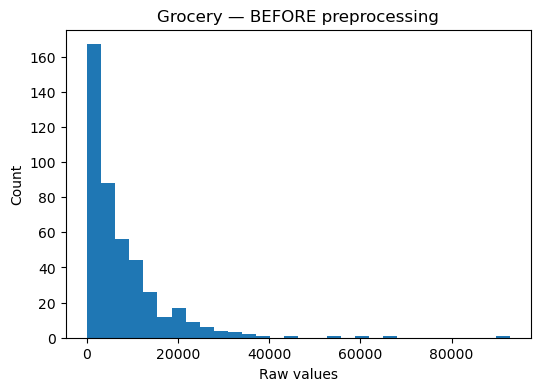

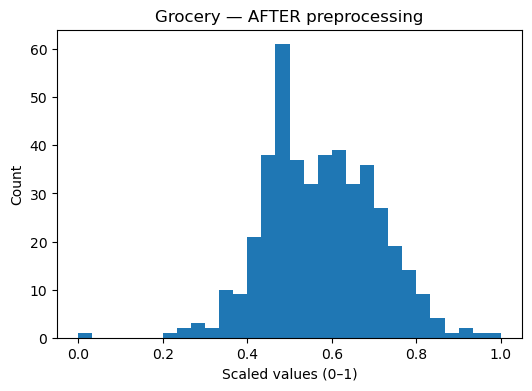

In [8]:
# TODO (student): choose ONE feature from spend_cols, e.g. "Grocery"
feature = "Grocery"

plt.figure(figsize=(6,4))
plt.hist(X0[feature], bins=30)
plt.title(f"{feature} — BEFORE preprocessing")
plt.xlabel("Raw values")
plt.ylabel("Count")
plt.show()

plt.figure(figsize=(6,4))
plt.hist(X_preprocessed[feature], bins=30)
plt.title(f"{feature} — AFTER preprocessing")
plt.xlabel("Scaled values (0–1)")
plt.ylabel("Count")
plt.show()


### ✍️ Student Answer (write here)
- Describe the **shape before**: ...
- Describe the **shape after**: ...
- Why is the after-plot better for clustering? ...


---
## 5) K-Means: Choose k (Elbow + Silhouette)
### What happens here
- Train K-Means for k = 2…10
- Plot **inertia** (elbow) and **silhouette**

✅ Decision rule:
- pick a k near the elbow (diminishing returns)
- prefer higher silhouette


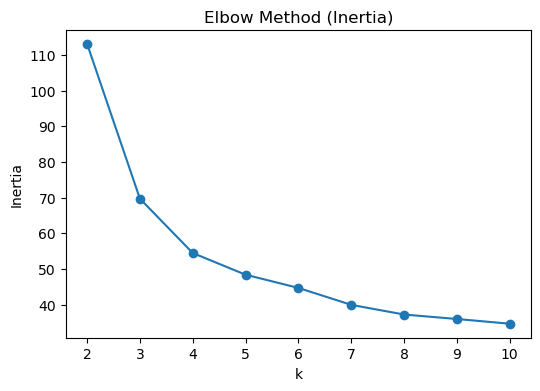

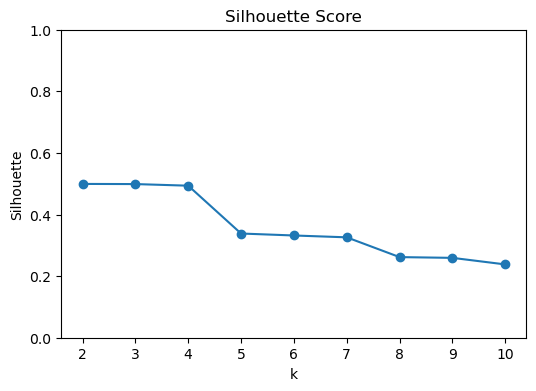

In [9]:
ks = range(2, 11)
inertias, sils = [], []

for k in ks:
    km = KMeans(n_clusters=k, random_state=random_state)
    labels = km.fit_predict(X)
    inertias.append(km.inertia_)
    sils.append(silhouette_score(X, labels))

plt.figure(figsize=(6,4))
plt.plot(list(ks), inertias, marker="o")
plt.title("Elbow Method (Inertia)")
plt.xlabel("k")
plt.ylabel("Inertia")
plt.show()

plt.figure(figsize=(6,4))
plt.plot(list(ks), sils, marker="o")
plt.title("Silhouette Score")
plt.xlabel("k")
plt.ylabel("Silhouette")
plt.ylim(0,1)
plt.show()


### ✍️ Student task: Choose k
Based on the two plots, choose a reasonable k and justify it.

- Chosen k = **...**
- Justification (2–3 lines) = ...


---
## 6) Fit Final K-Means Model
### What happens here
- Fit K-Means using your chosen **k**
- Report silhouette score
- Visualise clusters in a simple 2D view (`Grocery` vs `Detergents_Paper`)

⚠️ Note: This is a 2D projection for interpretation; the model used **all features**.


KMeans k = 4 | silhouette = 0.494


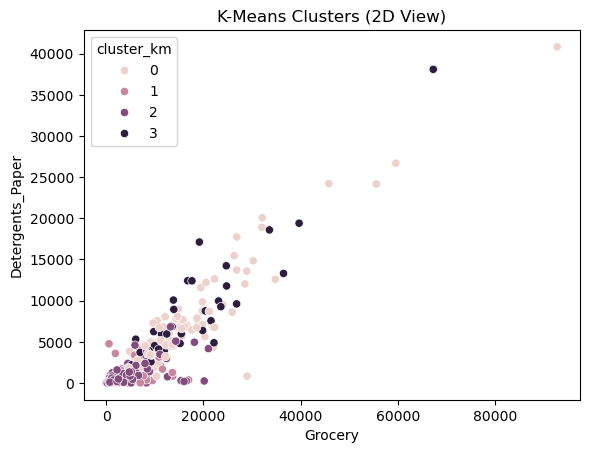

In [10]:
# TODO (student): set your chosen k here (example: 4)
k = 4

km = KMeans(n_clusters=k, random_state=random_state)
y_km = km.fit_predict(X)

print("KMeans k =", k, "| silhouette =", round(silhouette_score(X, y_km), 3))

X_plot = X0.copy()
X_plot["cluster_km"] = y_km

sns.scatterplot(data=X_plot, x="Grocery", y="Detergents_Paper", hue="cluster_km")
plt.title("K-Means Clusters (2D View)")
plt.show()


### ✍️ Interpretation prompt
Describe the clusters qualitatively (low/medium/high spenders). What might these segments represent?


---
## 7) Hierarchical Clustering (Agglomerative)
### Why we do this
Hierarchical clustering provides an alternative to K-Means. If results are similar, it suggests the segmentation is **stable**.


Agglomerative (ward) k = 4 | silhouette = 0.493


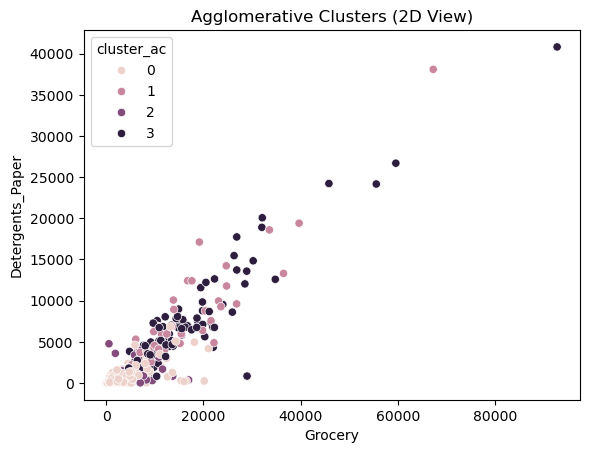

In [11]:
ac = AgglomerativeClustering(n_clusters=k, linkage="ward")
y_ac = ac.fit_predict(X)

print("Agglomerative (ward) k =", k, "| silhouette =", round(silhouette_score(X, y_ac), 3))

X_plot["cluster_ac"] = y_ac
sns.scatterplot(data=X_plot, x="Grocery", y="Detergents_Paper", hue="cluster_ac")
plt.title("Agglomerative Clusters (2D View)")
plt.show()


---
## 8) Compare K-Means vs Agglomerative (Optional but recommended)
### What happens here
We compute how much the two labelings agree.

✍️ **Student task:** Run and interpret the agreement percentage.


In [12]:
from sklearn.metrics import pair_confusion_matrix

pcm = pair_confusion_matrix(y_km, y_ac)
agreement = pcm.diagonal().sum() / pcm.sum()

print(f"Agreement ≈ {agreement*100:.2f}%")


Agreement ≈ 99.69%


### ✍️ Student Answer
- If agreement is high, what does that suggest about stability? ...


---
## 9) DBSCAN (Noise / Outlier Detection)
### What happens here
DBSCAN finds dense regions and labels sparse points as **noise** (-1).

✍️ **Student task:** Try changing `eps` and observe how the number of clusters/noise changes.


DBSCAN labels: [-1  0  1  2  3  4  5] (noise = -1)


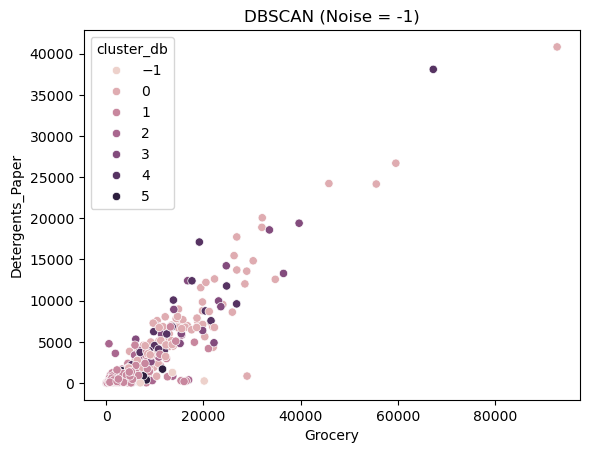

In [13]:
# TODO (student): you may try eps=0.3, 0.5, 0.7 and see how results change
db = DBSCAN(eps=0.5, min_samples=5)
y_db = db.fit_predict(X)

X_plot["cluster_db"] = y_db
print("DBSCAN labels:", np.unique(y_db), "(noise = -1)")

sns.scatterplot(data=X_plot, x="Grocery", y="Detergents_Paper", hue="cluster_db")
plt.title("DBSCAN (Noise = -1)")
plt.show()


---
## 🧾 Final Summary (Fill in)
Complete the short summary below.

### Results
- Chosen k = **...**
- K-Means silhouette = **...**
- Agglomerative silhouette = **...**
- DBSCAN: number of clusters (excluding noise) = **...**, noise points = **...**

### Conclusion (3–5 lines)
- Which model would you choose for **customer segmentation** and why?
- When would DBSCAN be preferable?
